In [127]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import seaborn as sns
from sklearn.feature_selection import SelectKBest,f_classif

# LOAD DATA

In [128]:
DATA_PATH = "BazaCut/"
FILIP_PATH = DATA_PATH + "wordsFilip/"
SEB_PATH = DATA_PATH + "wordsSebastian/"
MARCIN_PATH = DATA_PATH + "wordsMarcin/"
PROF_PATH = DATA_PATH + "wordsProfessor/"
no_of_words = 30
prefixes = ["F","S","M","L"]
Fs = 48000
words_filip = [i for i in range(no_of_words)]
words_seb = [i for i in range(no_of_words)]
words_marcin = [i for i in range(no_of_words)]
words_prof = [i for i in range(no_of_words)]

for i in range(1, no_of_words+1):
    file_name = "word"+str(i)+"_F"+".wav"
    y, sr = librosa.load(FILIP_PATH+file_name, sr=None)
    words_filip[i-1] = y

for i in range(1, no_of_words+1):
    file_name = "word"+str(i)+"_S"+".wav"
    y, sr = librosa.load(SEB_PATH+file_name, sr=None)
    words_seb[i-1] = y

for i in range(1, no_of_words+1):
    file_name = "word"+str(i)+"_M"+".wav"
    y, sr = librosa.load(MARCIN_PATH+file_name, sr=None)
    words_marcin[i-1] = y

for i in range(1, no_of_words+1):
    file_name = "word"+str(i)+"_L"+".wav"
    y, sr = librosa.load(PROF_PATH+file_name, sr=None)
    words_prof[i-1] = y


# MFCC (Mel Frequency Cepstral Coefficients) and Deltta MFCC

In [129]:
# Ekstrakcja MFCC (np. 13 współczynników)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Dodatkowe cechy: delty MFCC
delta_mfcc = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# Połączenie cech w jedną macierz
features = np.concatenate([mfcc, delta_mfcc, delta2_mfcc], axis=0)

mfcc_features_no = 13
#Problem: w wyniku mfcc mamy macierz (13,x). Ilość kolumn dla każdego słowa jest inna. Nie da się 
#dać do numpy array
mfcc_filip = [i for i in range(no_of_words)]
mfcc_delta_filip = [i for i in range(no_of_words)]
mfcc_delta2_filip = [i for i in range(no_of_words)]
for i, word in enumerate(words_filip):
    mfcc_filip[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_filip[i] = librosa.feature.delta(mfcc_filip[i])
    mfcc_delta2_filip[i] =  librosa.feature.delta(mfcc_filip[i], order=2)


mfcc_seb = [i for i in range(no_of_words)]
mfcc_delta_seb = [i for i in range(no_of_words)]
mfcc_delta2_seb = [i for i in range(no_of_words)]
for i, word in enumerate(words_seb):
    mfcc_seb[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_seb[i] = librosa.feature.delta(mfcc_seb[i])
    mfcc_delta2_seb[i] =  librosa.feature.delta(mfcc_seb[i], order=2)

mfcc_marcin = [i for i in range(no_of_words)]
mfcc_delta_marcin = [i for i in range(no_of_words)]
mfcc_delta2_marcin = [i for i in range(no_of_words)]
for i, word in enumerate(words_marcin):
    mfcc_marcin[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_marcin[i] = librosa.feature.delta(mfcc_marcin[i])
    mfcc_delta2_marcin[i] =  librosa.feature.delta(mfcc_marcin[i], order=2)


mfcc_prof = [i for i in range(no_of_words)]
mfcc_delta_prof = [i for i in range(no_of_words)]
mfcc_delta2_prof= [i for i in range(no_of_words)]
for i, word in enumerate(words_prof):
    mfcc_prof[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_prof[i] = librosa.feature.delta(mfcc_prof[i])
    mfcc_delta2_prof[i] =  librosa.feature.delta(mfcc_prof[i], order=2)

# Using SVM

In [130]:
mfcc_filip_mean = np.zeros((no_of_words,mfcc_features_no))
mfcc_seb_mean = np.zeros((no_of_words,mfcc_features_no))
mfcc_marcin_mean= np.zeros((no_of_words,mfcc_features_no))
mfcc_prof_mean= np.zeros((no_of_words,mfcc_features_no))

for i in range(no_of_words):
    mfcc_filip_mean[i,0:mfcc_features_no] = np.mean(mfcc_filip[i],axis=1)
    mfcc_seb_mean[i,0:mfcc_features_no] = np.mean(mfcc_seb[i],axis=1)
    mfcc_marcin_mean[i,0:mfcc_features_no] = np.mean(mfcc_marcin[i],axis=1)
    mfcc_prof_mean[i,0:mfcc_features_no] = np.mean(mfcc_prof[i],axis=1)

feature_vector = np.concatenate((mfcc_filip_mean, mfcc_seb_mean,mfcc_marcin_mean,mfcc_prof_mean))
labelsF = np.zeros(mfcc_filip_mean.shape[0])
labelsS = np.zeros(mfcc_filip_mean.shape[0])+1
labelsM = np.zeros(mfcc_filip_mean.shape[0])+2
labelsL = np.zeros(mfcc_filip_mean.shape[0])+3
labels = np.concatenate((labelsF, labelsS,labelsM,labelsL))

In [131]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.6, random_state=42)
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVM
svm = SVC(kernel='rbf', C=1.0, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8611111111111112
              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80        22
         1.0       0.88      0.83      0.86        18
         2.0       0.88      0.82      0.85        17
         3.0       0.94      1.00      0.97        15

    accuracy                           0.86        72
   macro avg       0.87      0.87      0.87        72
weighted avg       0.86      0.86      0.86        72



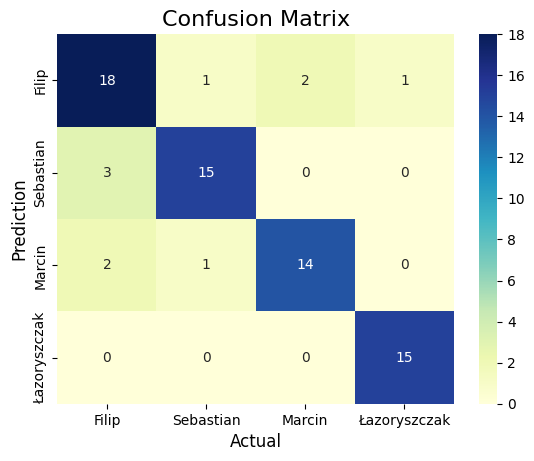

In [132]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Random Forest

In [133]:


rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8194444444444444
              precision    recall  f1-score   support

         0.0       0.80      0.73      0.76        22
         1.0       0.94      0.83      0.88        18
         2.0       0.93      0.76      0.84        17
         3.0       0.68      1.00      0.81        15

    accuracy                           0.82        72
   macro avg       0.84      0.83      0.82        72
weighted avg       0.84      0.82      0.82        72



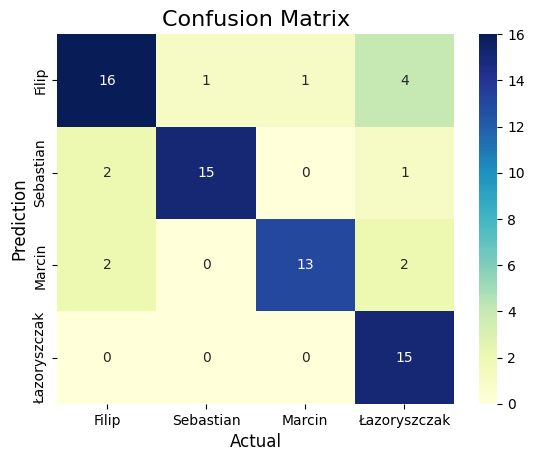

In [134]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Multilayer Perceptron

In [135]:
# Step 3: Train the Multilayer Perceptron Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 100,100), activation='relu', solver='adam', 
                         max_iter=2000, random_state=42)
mlp_clf.fit(X_train, y_train)

# Step 4: Evaluate the MLP Classifier
mlp_pred = mlp_clf.predict(X_test)
print("MLP Accuracy:", accuracy_score(y_test, mlp_pred))
print("MLP Classification Report:\n", classification_report(y_test, mlp_pred))

MLP Accuracy: 0.8472222222222222
MLP Classification Report:
               precision    recall  f1-score   support

         0.0       0.88      0.68      0.77        22
         1.0       0.73      0.89      0.80        18
         2.0       0.94      0.88      0.91        17
         3.0       0.88      1.00      0.94        15

    accuracy                           0.85        72
   macro avg       0.86      0.86      0.85        72
weighted avg       0.86      0.85      0.85        72



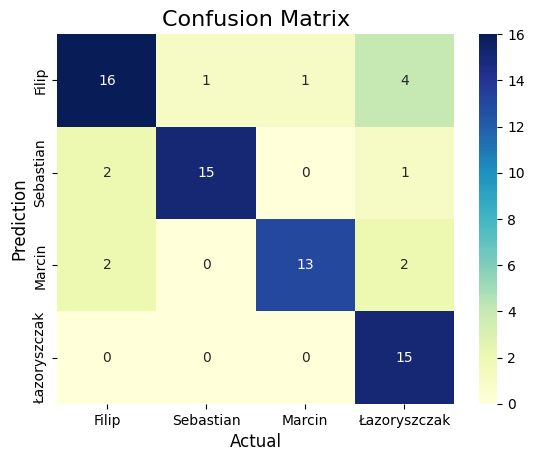

In [136]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Spectral Features
### Spectral Centroid, Spectral Bandwidth, Spectral Contrast, Spectral Flatness

In [137]:
spectral_features_no = 4

spectral_features_filip = [i for i in range(no_of_words)]
for i, word in enumerate(words_filip):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_filip[i] = spectral_features_vector

spectral_features_seb = [i for i in range(no_of_words)]
for i, word in enumerate(words_seb):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_seb[i] = spectral_features_vector


spectral_features_marcin = [i for i in range(no_of_words)]
for i, word in enumerate(words_marcin):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_marcin[i] = spectral_features_vector


spectral_features_prof = [i for i in range(no_of_words)]
for i, word in enumerate(words_prof):
    spectral_features_vector = np.zeros(4)
    spectral_features_vector[0] = np.mean(librosa.feature.spectral_centroid(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[1] = np.mean(librosa.feature.spectral_bandwidth(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[2] = np.mean(librosa.feature.spectral_contrast(y=word, sr=sr),axis=1)[0]
    spectral_features_vector[3] = np.mean(librosa.feature.spectral_flatness(y=word),axis=1)[0]
    spectral_features_prof[i] = spectral_features_vector


feature_vector = np.concatenate((spectral_features_filip, spectral_features_seb,spectral_features_marcin,spectral_features_prof))

# SVM

In [138]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.5, random_state=42)
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the SVM
svm = SVC(kernel='rbf', C=1.0, random_state=42)
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.7833333333333333
              precision    recall  f1-score   support

         0.0       0.83      0.62      0.71        16
         1.0       0.68      0.88      0.77        17
         2.0       0.73      0.73      0.73        15
         3.0       1.00      0.92      0.96        12

    accuracy                           0.78        60
   macro avg       0.81      0.79      0.79        60
weighted avg       0.80      0.78      0.78        60



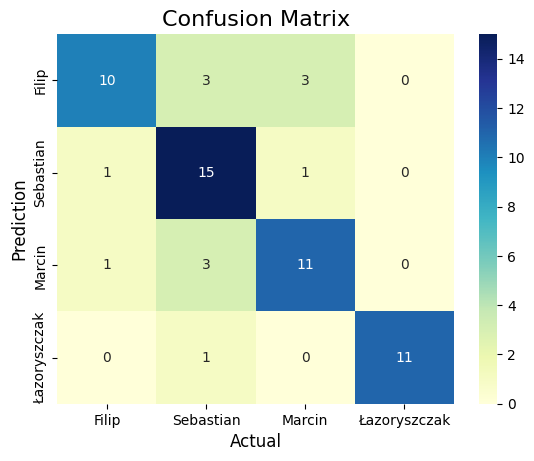

In [139]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Random Forest

In [140]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.8166666666666667
              precision    recall  f1-score   support

         0.0       0.83      0.62      0.71        16
         1.0       0.75      0.88      0.81        17
         2.0       0.76      0.87      0.81        15
         3.0       1.00      0.92      0.96        12

    accuracy                           0.82        60
   macro avg       0.84      0.82      0.82        60
weighted avg       0.83      0.82      0.81        60



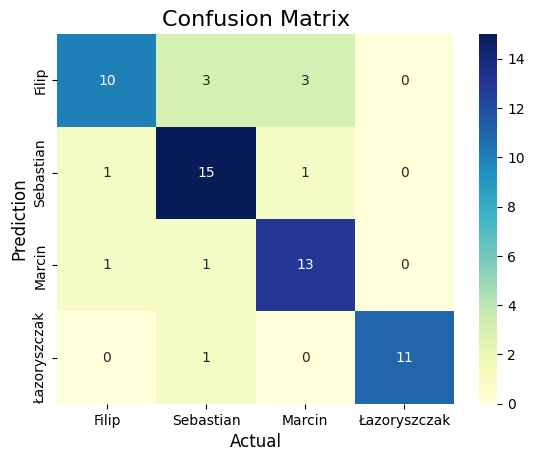

In [141]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Multilayer Perceptron

In [142]:
# Step 3: Train the Multilayer Perceptron Classifier
mlp_clf = MLPClassifier(hidden_layer_sizes=(100,100,100,20), activation='relu', solver='adam', 
                         max_iter=3000, random_state=42)
mlp_clf.fit(X_train, y_train)

# Step 4: Evaluate the MLP Classifier
mlp_pred = mlp_clf.predict(X_test)
print("MLP Accuracy:", accuracy_score(y_test, mlp_pred))
print("MLP Classification Report:\n", classification_report(y_test, mlp_pred))

MLP Accuracy: 0.8
MLP Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.50      0.64        16
         1.0       0.68      0.88      0.77        17
         2.0       0.78      0.93      0.85        15
         3.0       1.00      0.92      0.96        12

    accuracy                           0.80        60
   macro avg       0.84      0.81      0.80        60
weighted avg       0.82      0.80      0.79        60



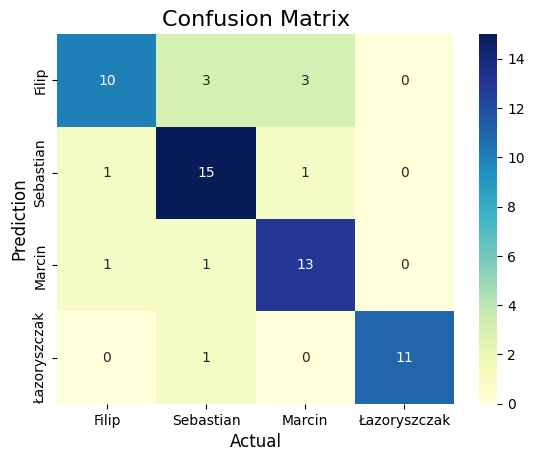

In [143]:
# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
ticks = ["Filip","Sebastian","Marcin","Łazoryszczak"]
# Plot the confusion matrix
sns.heatmap(cm, annot=True,fmt='d', cmap='YlGnBu',xticklabels=ticks, yticklabels=ticks )
plt.ylabel('Prediction',fontsize=12)
plt.xlabel('Actual',fontsize=12)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

# Feature Select
## Do wybrania najelpszeych cech użyto SelectKBest - wybranie najlepszych k cech na podstawie danego krytetrium

In [144]:
#Funckja do spłaszczania tablicy 3d do 2d. Robi flatten na ostatnich dwóch wymiarach
def flatten_features(data,X,Y,Z):

    mfcc_cut = np.zeros((X,Y,Z))
    mfcc_final = np.zeros((X,Y*Z))

    for i in range(X):
        for j in range(Y):
            mfcc_cut[i][j] =  data[i][j][:Z]

        to_flatten =  mfcc_cut[i]
        mfcc_final[i] = to_flatten.flatten()
    return mfcc_final

## MFCC

In [145]:
mfcc_features_no = 13
mfcc_filip = [i for i in range(no_of_words)]
mfcc_delta_filip = [i for i in range(no_of_words)]
mfcc_delta2_filip = [i for i in range(no_of_words)]
for i, word in enumerate(words_filip):
    mfcc_filip[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_filip[i] = librosa.feature.delta(mfcc_filip[i])
    mfcc_delta2_filip[i] =  librosa.feature.delta(mfcc_filip[i], order=2)


mfcc_seb = [i for i in range(no_of_words)]
mfcc_delta_seb = [i for i in range(no_of_words)]
mfcc_delta2_seb = [i for i in range(no_of_words)]
for i, word in enumerate(words_seb):
    mfcc_seb[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_seb[i] = librosa.feature.delta(mfcc_seb[i])
    mfcc_delta2_seb[i] =  librosa.feature.delta(mfcc_seb[i], order=2)

mfcc_marcin = [i for i in range(no_of_words)]
mfcc_delta_marcin = [i for i in range(no_of_words)]
mfcc_delta2_marcin = [i for i in range(no_of_words)]
for i, word in enumerate(words_marcin):
    mfcc_marcin[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_marcin[i] = librosa.feature.delta(mfcc_marcin[i])
    mfcc_delta2_marcin[i] =  librosa.feature.delta(mfcc_marcin[i], order=2)


mfcc_prof = [i for i in range(no_of_words)]
mfcc_delta_prof = [i for i in range(no_of_words)]
mfcc_delta2_prof = [i for i in range(no_of_words)]
for i, word in enumerate(words_prof):
    mfcc_prof[i] = librosa.feature.mfcc(y=word, sr=Fs, n_mfcc=mfcc_features_no)
    mfcc_delta_prof[i] = librosa.feature.delta(mfcc_prof[i])
    mfcc_delta2_prof[i] =  librosa.feature.delta(mfcc_prof[i], order=2)

# Macierze mfcc mają wymiar (30,13,x), gdzie x ma różną długość dla każdego słowwa.
# Może obciąż wszystkie dla najmniejszej długości
# to może ograniczyć i zrobić flatten
least_to_take = 50

mfcc_filip_final = flatten_features(mfcc_filip, no_of_words, mfcc_features_no,least_to_take)
mfcc_seb_final = flatten_features(mfcc_seb, no_of_words, mfcc_features_no,least_to_take)
mfcc_marcin_final = flatten_features(mfcc_marcin, no_of_words, mfcc_features_no,least_to_take)
mfcc_prof_final = flatten_features(mfcc_prof, no_of_words, mfcc_features_no,least_to_take)


print()
feature_vector_mfcc = np.concatenate((mfcc_filip_final, mfcc_seb_final,mfcc_marcin_final,mfcc_prof_final))
#Teraz cechy są (30,650)
# a feature vector jest (90,650).
print(feature_vector_mfcc.shape)


(120, 650)


## Przykład użycia SelectKBest

# SVM 

In [146]:
X_train, X_test, y_train, y_test = train_test_split(feature_vector_mfcc, labels, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=f_classif, k=300)  
X_train_selected = selector.fit_transform(X_train, y_train)  
X_test_selected = selector.transform(X_test)  

print(X_train_selected.shape, X_test_selected.shape)

# Normalize the features
scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

# Train the SVM
svm = SVC(kernel='sigmoid', C=1.0, random_state=42)
svm.fit(X_train_selected, y_train)

y_pred = svm.predict(X_test_selected)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print(classification_report(y_test, y_pred))

(96, 300) (24, 300)
Accuracy: 0.7083333333333334
              precision    recall  f1-score   support

         0.0       0.50      0.83      0.62         6
         1.0       1.00      0.29      0.44         7
         2.0       0.75      0.86      0.80         7
         3.0       1.00      1.00      1.00         4

    accuracy                           0.71        24
   macro avg       0.81      0.74      0.72        24
weighted avg       0.80      0.71      0.69        24



## Spectral

In [147]:
spectral_features_no = 4

spectral_features_filip = [i for i in range(no_of_words)]
for i, word in enumerate(words_filip):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_filip[i] = spectral_features_vector

spectral_features_seb = [i for i in range(no_of_words)]
for i, word in enumerate(words_seb):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_seb[i] = spectral_features_vector


spectral_features_marcin = [i for i in range(no_of_words)]
for i, word in enumerate(words_marcin):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_marcin[i] = spectral_features_vector

spectral_features_prof= [i for i in range(no_of_words)]
for i, word in enumerate(words_prof):
    spectral_features_vector = [0]*10
    spectral_features_vector[0] = librosa.feature.spectral_centroid(y=word, sr=sr)[0]
    spectral_features_vector[1] = librosa.feature.spectral_bandwidth(y=word, sr=sr)[0]
    for j in range(2,9):
        spectral_features_vector[j] = librosa.feature.spectral_contrast(y=word, sr=sr)[j-3]
    spectral_features_vector[9] = librosa.feature.spectral_flatness(y=word)[0]
    spectral_features_prof[i] = spectral_features_vector


least_to_take = 50

spectral_filip_final = flatten_features(spectral_features_filip, no_of_words, 10, least_to_take)
spectral_seb_final = flatten_features(spectral_features_seb, no_of_words, 10, least_to_take)
spectral_marcin_final = flatten_features(spectral_features_marcin, no_of_words, 10, least_to_take)
spectral_prof_final = flatten_features(spectral_features_prof, no_of_words, 10, least_to_take)

feature_vector_spec = np.concatenate((spectral_filip_final, spectral_seb_final,spectral_marcin_final,spectral_prof_final))

In [148]:

X_train, X_test, y_train, y_test = train_test_split(feature_vector_spec, labels, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=f_classif, k=400)  
X_train_selected = selector.fit_transform(X_train, y_train)  
X_test_selected = selector.transform(X_test)  

print(X_train_selected.shape, X_test_selected.shape)

# Normalize the features
scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

# Train the SVM
svm = SVC(kernel='sigmoid', C=1.0, random_state=42)
svm.fit(X_train_selected, y_train)

y_pred = svm.predict(X_test_selected)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print(classification_report(y_test, y_pred))

(96, 400) (24, 400)
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

         0.0       0.62      0.83      0.71         6
         1.0       0.40      0.29      0.33         7
         2.0       0.71      0.71      0.71         7
         3.0       1.00      1.00      1.00         4

    accuracy                           0.67        24
   macro avg       0.68      0.71      0.69        24
weighted avg       0.65      0.67      0.65        24



## Połączenie MFCC i Spectral

In [149]:
feature_vector = np.concatenate((feature_vector_mfcc, feature_vector_spec), axis=1)
X_train, X_test, y_train, y_test = train_test_split(feature_vector, labels, test_size=0.2, random_state=42)

selector = SelectKBest(score_func=f_classif, k=500)  
X_train_selected = selector.fit_transform(X_train, y_train)  
X_test_selected = selector.transform(X_test)  

print(X_train_selected.shape, X_test_selected.shape)

# Normalize the features
scaler = StandardScaler()
X_train_selected = scaler.fit_transform(X_train_selected)
X_test_selected = scaler.transform(X_test_selected)

# Train the SVM
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train_selected, y_train)

y_pred = svm.predict(X_test_selected)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed classification report
print(classification_report(y_test, y_pred))

(96, 500) (24, 500)
Accuracy: 0.7916666666666666
              precision    recall  f1-score   support

         0.0       0.60      1.00      0.75         6
         1.0       0.80      0.57      0.67         7
         2.0       1.00      0.71      0.83         7
         3.0       1.00      1.00      1.00         4

    accuracy                           0.79        24
   macro avg       0.85      0.82      0.81        24
weighted avg       0.84      0.79      0.79        24

